# BCM for double RCM

22 October 2023

In [352]:
import pandas as pd
import gpflow
import sys
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code/guepard_repo/')
import guepard
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import boxcox

In [416]:
from utils.areal_plots import mean_ci_plots

In [353]:
from gpflow.conditionals.util import sample_mvn
import tensorflow as tf

In [417]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [549]:
dir = '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/'
df1 = pd.read_csv(
    dir + 'pr_WAS-44i_MPI-M-MPI-ESM-LR_historical_r1i1p1_MPI-CSC-REMO2009_v1_mon_196101-197012.csv', index_col=0)
df2 = pd.read_csv(
    dir + 'pr_WAS-44i_MPI-M-MPI-ESM-MR_historical_r1i1p1_IITM-RegCM4-4_v5_mon_196101-196512.csv', index_col=0)


In [550]:
df1 = df1[df1['time'] < '1965-12-30']

In [551]:
df1['time'] = pd.to_datetime(df1['time'].values)
df2['time'] = pd.to_datetime(df2['time'].values)

In [508]:
df2

,time,lon,lat,pr
0,1961-01-01,60.25,20.25,1.121867
1,1961-01-01,60.25,20.75,1.082617
2,1961-01-01,60.25,21.25,0.773363
3,1961-01-01,60.25,21.75,0.619346
4,1961-01-01,60.25,22.25,0.533917
...,...,...,...,...
215995,1965-12-01,104.75,37.75,0.210052
215996,1965-12-01,104.75,38.25,0.219739
215997,1965-12-01,104.75,38.75,0.269641
215998,1965-12-01,104.75,39.25,0.388051


In [509]:
df = pd.concat([df1, df2])

In [510]:
df['time'] = pd.to_numeric(pd.to_datetime(df['time']))

In [511]:
# Make sure the data is sorted
df.sort_values(by=['time', 'lat', 'lon'], inplace=True)

In [512]:
df

,lon,lat,time,pr
0,60.25,20.25,-283996800000000000,0.393123
0,60.25,20.25,-283996800000000000,1.121867
4800,60.75,20.25,-283996800000000000,0.342650
40,60.75,20.25,-283996800000000000,1.375889
9600,61.25,20.25,-283996800000000000,0.418020
...,...,...,...,...
215919,103.75,39.75,-128908800000000000,0.407697
427139,104.25,39.75,-128908800000000000,0.037485
215959,104.25,39.75,-128908800000000000,0.425008
431939,104.75,39.75,-128908800000000000,0.038393


## Preprocessing

### Inputs

In [513]:
input_scaler = StandardScaler()
input_scaler.fit(df[['time', 'lon', 'lat']])

StandardScaler()

In [514]:
in_arr = input_scaler.transform(df[['time', 'lon', 'lat']])

### Outputs

In [518]:
out_arr_tr, lmbd = boxcox(df['pr'].values+0.001)
df['pr_tr'] = out_arr_tr

In [520]:
output_scaler = StandardScaler()
output_scaler.fit(df[['pr_tr']])
out_arr = output_scaler.transform(df[['pr_tr']])

## Model and submodels

In [521]:
# seperate x and y
num_split = 100

# list of num_split np.arrays
Xl = np.array_split(in_arr[:80000], num_split)
Yl = np.array_split(out_arr[:80000], num_split)

kernel = gpflow.kernels.Matern32()
noise_var = 0.01

In [522]:
# list of num_split GPR models
submodels = guepard.utilities.get_gpr_submodels(
    zip(Xl, Yl), kernel, noise_variance=noise_var)

In [523]:
m_rbcm = guepard.baselines.Ensemble(
    models=submodels, method=guepard.baselines.EnsembleMethods.RBCM, weighting=guepard.baselines.WeightingMethods.VAR)

In [524]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_rbcm.training_loss,
                        m_rbcm.trainable_variables, options=dict(maxiter=100))
gpflow.utilities.print_summary(m_rbcm)

╒═════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Ensemble.kernel.variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.61928 │
│ Ensemble.models[0].kernel.variance      │           │                  │         │             │         │         │         │
│ Ensemble.models[1].kernel.variance      │           │                  │         │             │         │         │         │
│ Ensemble.models[2].kernel.variance      │           │                  │         │             │         │         │         │
│ Ensemble.models[3].kernel.variance      │           │                  │         │             

In [525]:
#remove duplicate rows
x_plot = np.unique(np.array(Xl).reshape(-1, 3), axis=0)

In [526]:
x_plot

array([[-1.70130587, -1.71291154, -1.68927752],
       [-1.70130587, -1.71291154, -1.6026479 ],
       [-1.70130587, -1.71291154, -1.51601829],
       ...,
       [-1.06772656,  1.71291154, -1.6026479 ],
       [-1.06772656,  1.71291154, -1.51601829],
       [-1.06772656,  1.71291154, -1.42938867]])

In [527]:
ypred, var = m_rbcm.predict_y(x_plot)
arr= np.stack((ypred.numpy().flatten(), var.numpy().flatten()), axis=1)
df_temp= pd.DataFrame(arr, columns=['pred0', 'var0'])

In [528]:
input_loc_arr = input_scaler.inverse_transform(np.array(x_plot).reshape(-1, 3))

In [529]:
# Create dataframe, apply inverse transform and calculate 95th percentile CI
df_temp['y_pred'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values.reshape(-1,1), lmbd))
df_temp['95th_u'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values.reshape(-1, 1) + 1.96 * np.sqrt(df_temp['var0'].values.reshape(-1, 1)), lmbd))
df_temp['95th_l'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp['pred0'].values.reshape(-1, 1) - 1.96 * np.sqrt(df_temp['var0'].values.reshape(-1, 1)), lmbd))
df_temp['CI'] = df_temp['95th_u'].fillna(0) - df_temp['95th_l'].fillna(0)

df_temp[['time', 'lon', 'lat']] = input_loc_arr
df_temp.set_index(['time', 'lon', 'lat'], inplace=True)

df_temp[['y_pred', '95th_u', '95th_l', 'CI']] = df_temp[[
    'y_pred', '95th_u', '95th_l', 'CI']].fillna(0)

In [599]:
df_temp.to_csv('data/output/rbcm_tr_2rcm_1961_1965.csv')

In [530]:
# To Data Array
ds = df_temp.to_xarray()
ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 90, lat: 40)
Coordinates:
  * time     (time) float64 -2.84e+17 -2.813e+17 ... -2.577e+17 -2.551e+17
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
Data variables:
    pred0    (time, lon, lat) float64 -0.6923 -0.7773 -0.9162 ... nan nan nan
    var0     (time, lon, lat) float64 0.3347 0.3276 0.3266 ... nan nan nan
    y_pred   (time, lon, lat) float64 0.9203 0.8438 0.7313 ... nan nan nan
    95th_u   (time, lon, lat) float64 2.678 2.462 2.173 1.926 ... nan nan nan
    95th_l   (time, lon, lat) float64 0.2904 0.2717 0.2412 ... nan nan nan
    CI       (time, lon, lat) float64 2.388 2.19 1.932 1.709 ... nan nan nan nan

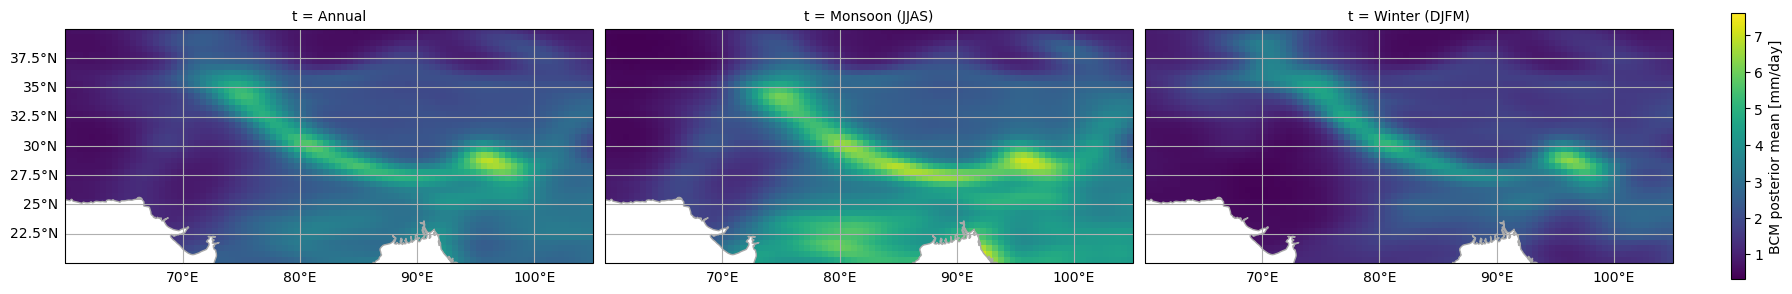

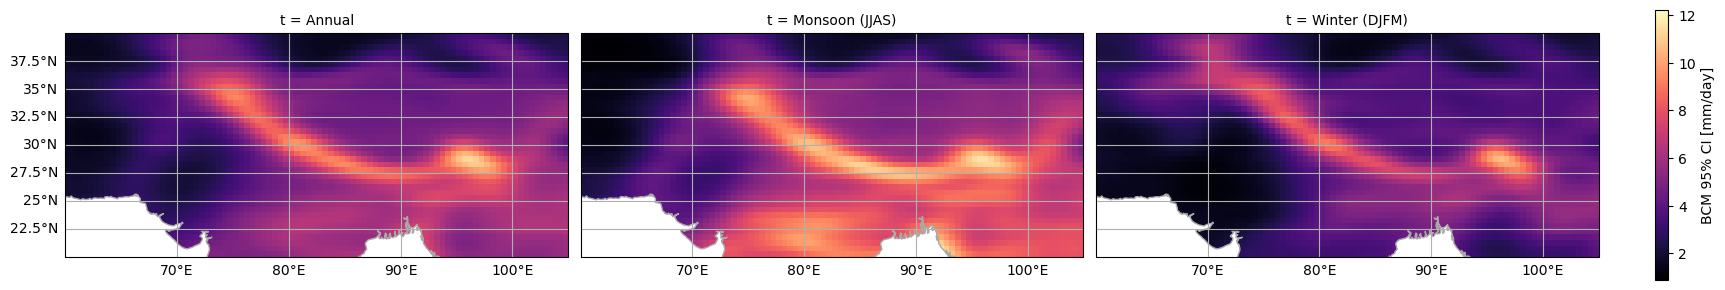

In [575]:
mean_ci_plots(ds)

## Checks with tradional averaging

In [552]:
df1.sort_values(['time','lon', 'lat'] , inplace=True)
df2.sort_values(['time','lon', 'lat'], inplace=True)

In [545]:
df1['time'] = pd.to_datetime(df1['time'])
df2['time'] = pd.to_datetime(df2['time'])

In [554]:
df2_ = df2.set_index(['time', 'lon', 'lat'])
ds2 = df2_.to_xarray()

In [555]:
ds2

<xarray.Dataset>
Dimensions:  (time: 60, lon: 90, lat: 40)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 1965-12-01
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
Data variables:
    pr       (time, lon, lat) float64 1.122 1.083 0.7734 ... 0.3881 0.4045

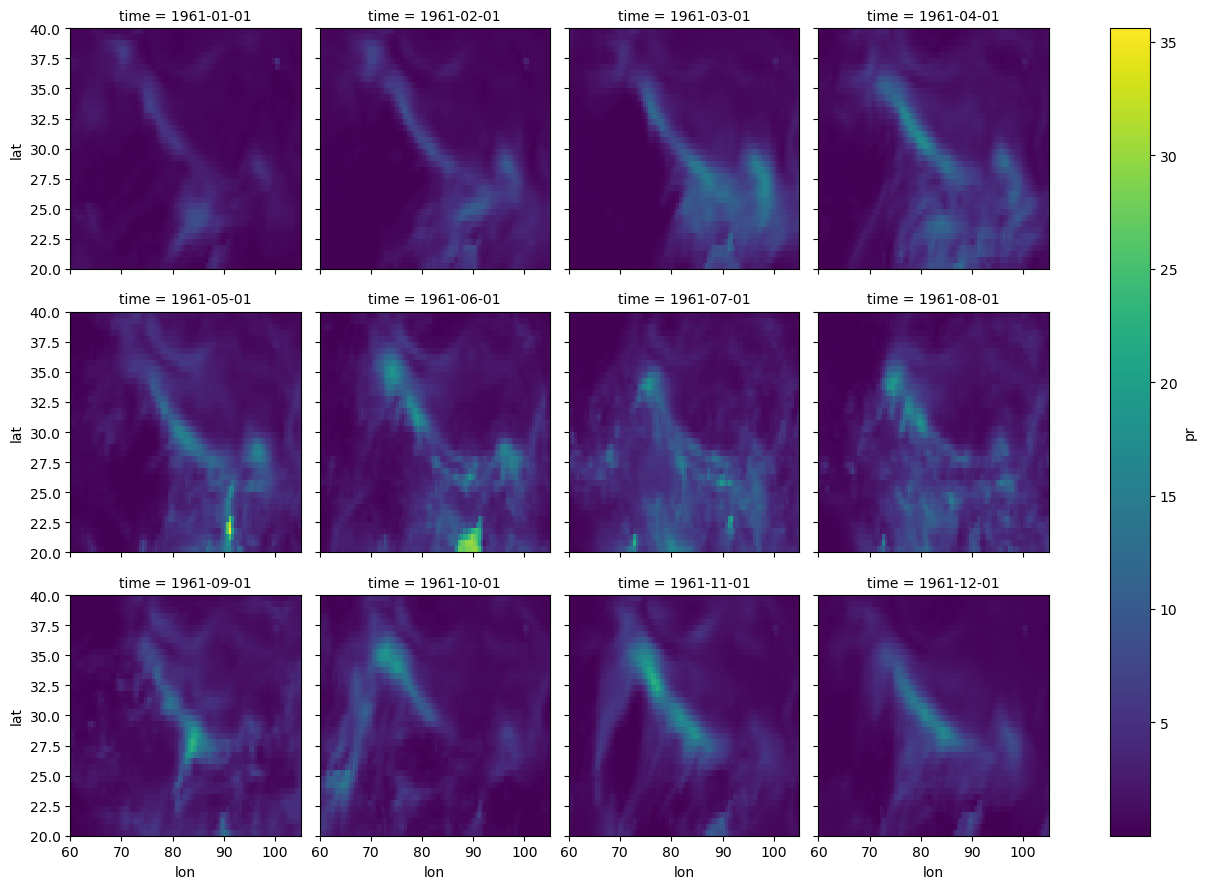

In [556]:
ds2.isel(time=slice(0,12)).pr.plot(x='lon', col='time', col_wrap=4)

In [557]:
df1_ = df1.set_index(['time', 'lon', 'lat'])
ds1 = df1_.to_xarray()
ds1

<xarray.Dataset>
Dimensions:  (time: 60, lon: 90, lat: 40)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 1965-12-01
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
Data variables:
    pr       (time, lon, lat) float64 0.3931 0.2305 0.05876 ... 0.1357 0.03839

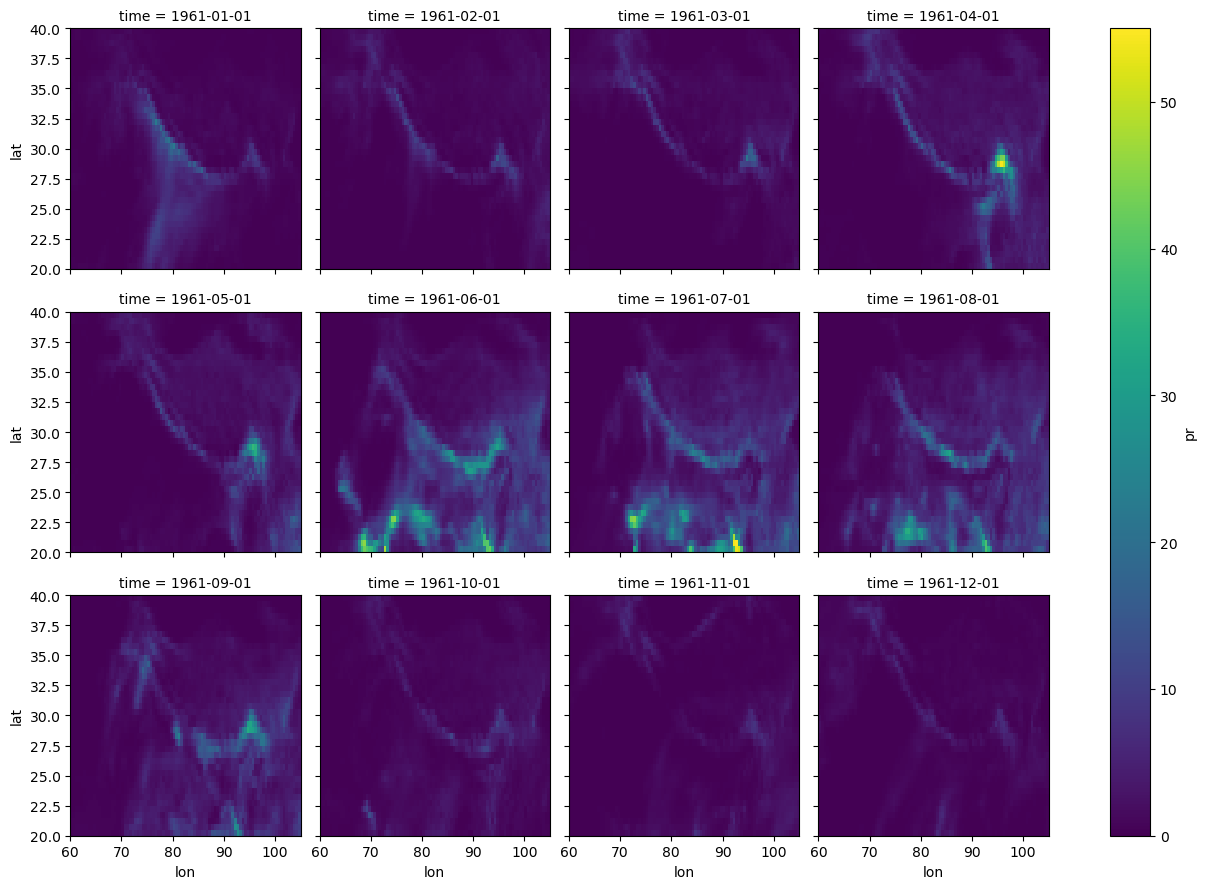

In [558]:
ds1.isel(time=slice(0,12)).pr.plot(x='lon', col='time', col_wrap=4)

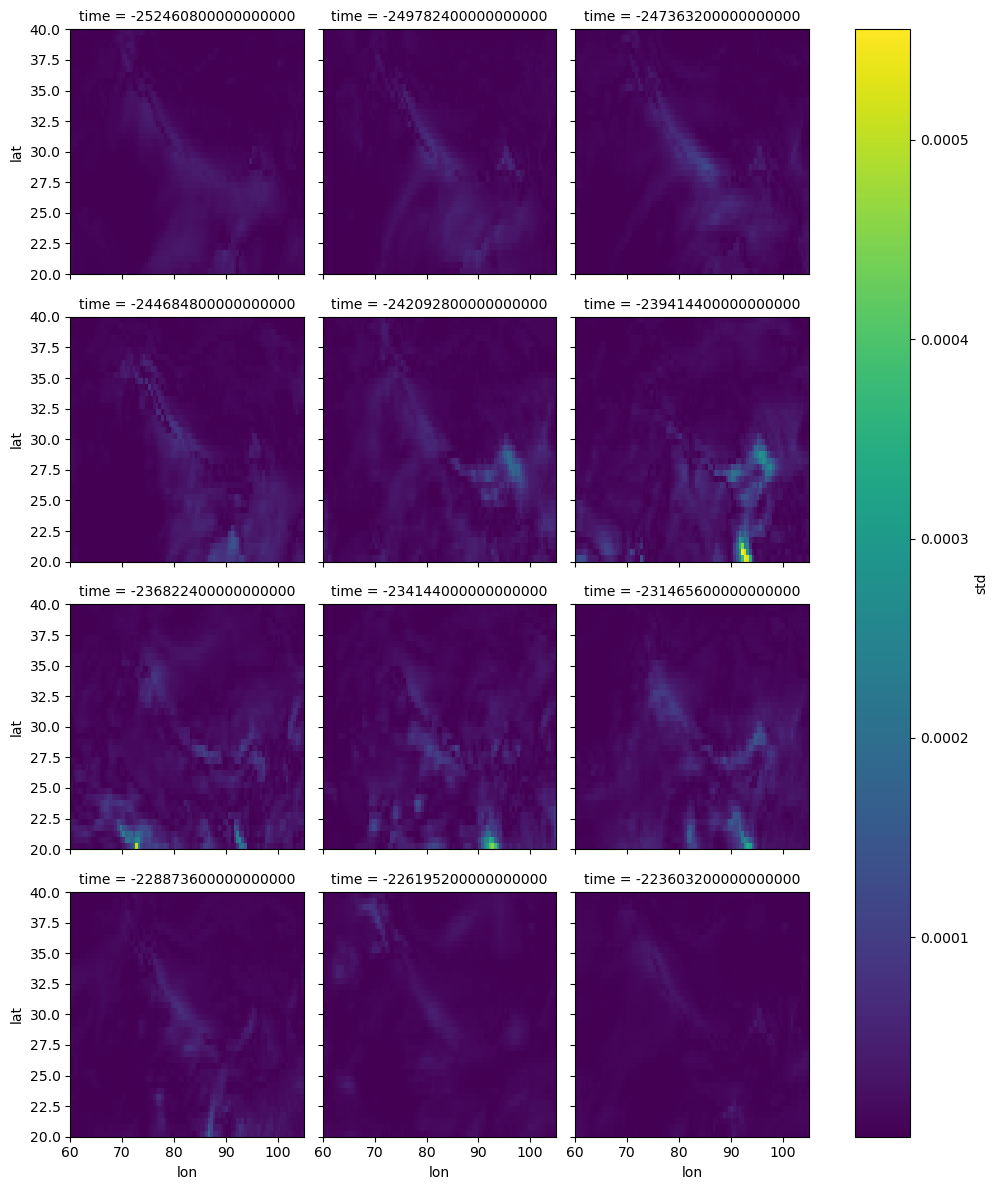

In [411]:
ds1.isel(time=slice(12, 24))['std'].plot(x='lon', col='time', col_wrap=3)

In [568]:
ds3 = ds2.interp_like(ds1, 'nearest')

In [569]:
ds1['y_pred'] = (ds1.pr + ds3.pr)/2

In [572]:
ds1['std'] = np.sqrt(((ds1.pr - ds1.y_pred)**2 + (ds3.pr - ds1.y_pred)**2)/2)
ds1['l95'] = ds1.y_pred - 1.96 * ds1['std']
ds1['u95'] = ds1.y_pred + 1.96 * ds1['std']
ds1['CI'] = ds1.u95 - ds1.l95

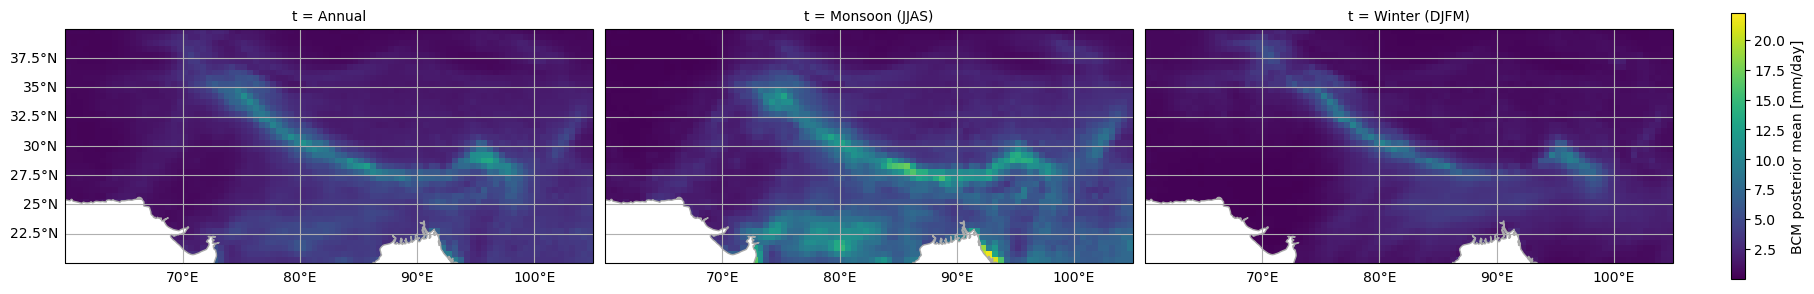

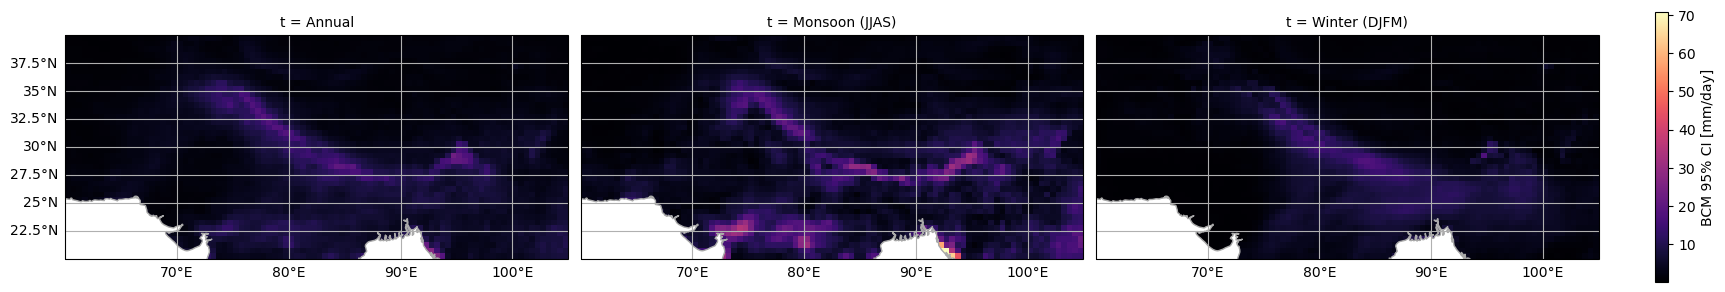

In [574]:
mean_ci_plots(ds1.isel(time=slice(0,12)))

In [597]:
df_trad = ds1[['time', 'lon', 'lat', 'y_pred']].to_dataframe()
df_trad.reset_index(inplace=True)
df_trad.to_csv('trad_1961_2rcm.csv', index=False)

## Comparison with APHRODITE

In [591]:
x_aphro_df = pd.read_csv('data/aphro_grid.csv')
#print(x_aphro_df)
x_aphro_df['time'] = pd.to_numeric(pd.to_datetime(x_aphro_df['time']))

In [592]:
x_aphro = input_scaler.transform(x_aphro_df[['time', 'lon', 'lat']])

In [593]:
ypred, var = m_rbcm.predict_y(x_aphro)
arr= np.stack((ypred.numpy().flatten(), var.numpy().flatten()), axis=1)
df_bcm= pd.DataFrame(arr, columns=['pred0', 'var0'])
df_bcm['y_pred'] = output_scaler.inverse_transform(inv_boxcox(
    df_bcm['pred0'].values.reshape(-1,1), lmbd))
df_bcm[['time', 'lon', 'lat']] = x_aphro_df[['time', 'lon', 'lat']]
df_bcm.set_index(['time', 'lon', 'lat'], inplace=True)

df_bcm.to_csv('data/outputs/bcm_aphrogrid_2rcm_1961.csv')

## Distribution plots


In [604]:
x_locs = np.array([[75, 36], [85, 29],[95, 30], [85, 32.5]])
x_locs_rep = np.tile(x_locs, (12, 1))

In [656]:
x_times = np.arange('1961', '1962', dtype='datetime64[M]').astype('datetime64[ns]')
x_times_num = pd.to_numeric(pd.to_datetime(x_times)).values
x_times_rep = np.repeat(x_times_num, 4)


In [657]:
x_times_rep

array([-283996800000000000, -283996800000000000, -283996800000000000,
       -283996800000000000, -281318400000000000, -281318400000000000,
       -281318400000000000, -281318400000000000, -278899200000000000,
       -278899200000000000, -278899200000000000, -278899200000000000,
       -276220800000000000, -276220800000000000, -276220800000000000,
       -276220800000000000, -273628800000000000, -273628800000000000,
       -273628800000000000, -273628800000000000, -270950400000000000,
       -270950400000000000, -270950400000000000, -270950400000000000,
       -268358400000000000, -268358400000000000, -268358400000000000,
       -268358400000000000, -265680000000000000, -265680000000000000,
       -265680000000000000, -265680000000000000, -263001600000000000,
       -263001600000000000, -263001600000000000, -263001600000000000,
       -260409600000000000, -260409600000000000, -260409600000000000,
       -260409600000000000, -257731200000000000, -257731200000000000,
       -257731200000

In [658]:
np.hstack((x_times_rep.reshape(-1,1), x_locs_rep))

array([[-2.839968e+17,  7.500000e+01,  3.600000e+01],
       [-2.839968e+17,  8.500000e+01,  2.900000e+01],
       [-2.839968e+17,  9.500000e+01,  3.000000e+01],
       [-2.839968e+17,  8.500000e+01,  3.250000e+01],
       [-2.813184e+17,  7.500000e+01,  3.600000e+01],
       [-2.813184e+17,  8.500000e+01,  2.900000e+01],
       [-2.813184e+17,  9.500000e+01,  3.000000e+01],
       [-2.813184e+17,  8.500000e+01,  3.250000e+01],
       [-2.788992e+17,  7.500000e+01,  3.600000e+01],
       [-2.788992e+17,  8.500000e+01,  2.900000e+01],
       [-2.788992e+17,  9.500000e+01,  3.000000e+01],
       [-2.788992e+17,  8.500000e+01,  3.250000e+01],
       [-2.762208e+17,  7.500000e+01,  3.600000e+01],
       [-2.762208e+17,  8.500000e+01,  2.900000e+01],
       [-2.762208e+17,  9.500000e+01,  3.000000e+01],
       [-2.762208e+17,  8.500000e+01,  3.250000e+01],
       [-2.736288e+17,  7.500000e+01,  3.600000e+01],
       [-2.736288e+17,  8.500000e+01,  2.900000e+01],
       [-2.736288e+17,  9.50

In [659]:
x_plot2 = input_scaler.transform(np.hstack((x_times_rep.reshape(-1,1), x_locs_rep)))

/Users/kenzatazi/miniconda3/envs/bcm4rcm/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [660]:
x_plot2

array([[-1.70130587, -0.57738591,  1.0395554 ],
       [-1.70130587,  0.19246197, -0.17325923],
       [-1.70130587,  0.96230985,  0.        ],
       [-1.70130587,  0.19246197,  0.43314808],
       [-1.6425006 , -0.57738591,  1.0395554 ],
       [-1.6425006 ,  0.19246197, -0.17325923],
       [-1.6425006 ,  0.96230985,  0.        ],
       [-1.6425006 ,  0.19246197,  0.43314808],
       [-1.58938617, -0.57738591,  1.0395554 ],
       [-1.58938617,  0.19246197, -0.17325923],
       [-1.58938617,  0.96230985,  0.        ],
       [-1.58938617,  0.19246197,  0.43314808],
       [-1.5305809 , -0.57738591,  1.0395554 ],
       [-1.5305809 ,  0.19246197, -0.17325923],
       [-1.5305809 ,  0.96230985,  0.        ],
       [-1.5305809 ,  0.19246197,  0.43314808],
       [-1.47367258, -0.57738591,  1.0395554 ],
       [-1.47367258,  0.19246197, -0.17325923],
       [-1.47367258,  0.96230985,  0.        ],
       [-1.47367258,  0.19246197,  0.43314808],
       [-1.41486732, -0.57738591,  1.039

In [688]:
ypred2, var2 = m_rbcm.predict_y(x_plot2)
arr2= np.stack((ypred2.numpy().flatten(), var2.numpy().flatten()), axis=1)
df_temp3= pd.DataFrame(arr2, columns=['pred0', 'var0'])

In [689]:
df_temp3['y_pred'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp3['pred0'].values.reshape(-1, 1), lmbd)).reshape(-1)
df_temp3['95th_u'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp3['pred0'].values.reshape(-1, 1) + 1.96 * np.sqrt(df_temp3['var0'].values.reshape(-1, 1)), lmbd))
df_temp3['95th_l'] = output_scaler.inverse_transform(inv_boxcox(
    df_temp3['pred0'].values.reshape(-1, 1) - 1.96 * np.sqrt(df_temp3['var0'].values.reshape(-1, 1)), lmbd))
df_temp3['CI'] = df_temp3['95th_u'] - df_temp3['95th_l']

df_temp3[['time', 'lon', 'lat']] = np.hstack((x_times_rep.reshape(-1, 1), x_locs_rep))
df_temp3.set_index(['time', 'lon', 'lat'], inplace=True)


In [ ]:

df_temp3[['y_pred', '95th_u', '95th_l', 'CI']] = df_temp[[
    'y_pred', '95th_u', '95th_l', 'CI']].fillna(0)

In [687]:
output_scaler.inverse_transform(inv_boxcox(
    df_temp2['pred0'].values.reshape(-1, 1), lmbd)).reshape(-1).shape


(48,)

In [690]:
df_temp3


pred0      var0    y_pred     95th_u    95th_l  \
time          lon  lat                                                       
-2.839968e+17 75.0 36.0  0.592335  0.320504  3.044786   7.149868  1.097559   
              85.0 29.0  0.687143  0.321692  3.295319   7.650580  1.203190   
              95.0 30.0  0.546855  0.320481  2.930165   6.923622  1.048835   
              85.0 32.5 -0.249043  0.320568  1.427209   3.796539  0.461600   
-2.813184e+17 75.0 36.0  0.785695  0.318833  3.572988   8.160088  1.331344   
              85.0 29.0  0.777015  0.319591  3.547806   8.119057  1.318478   
              95.0 30.0  0.851457  0.318862  3.768446   8.533933  1.418631   
              85.0 32.5 -0.176299  0.318933  1.529979   4.014859  0.499187   
-2.788992e+17 75.0 36.0  0.949086  0.318492  4.074240   9.109089  1.558205   
              85.0 29.0  0.940148  0.319122  4.045451   9.061479  1.543447   
              95.0 30.0  1.136075  0.318544  4.714823  10.303644  1.855582   
              85.0 32.5  0.044568  0.318617  1.880867   4.768884  0.628647   
-2.762208e+17 75.0 36.0  1.065173  0.318445  4.463171   9.836265  1.737925   
              85.0 29.0  1.154579  0.319025  4.782312  10.433749  1.885986   
              95.0 30.0  1.289627  0.318509  5.298314  11.371951  2.133931   
              85.0 32.5  0.322819  0.318587  2.415233   5.876376  0.838463   
-2.736288e+17 75.0 36.0  1.016983  0.318424  4.298300   9.528666  1.661434   
              85.0 29.0  1.217534  0.318996  5.017664  10.865857  1.997765   
              95.0 30.0  1.210481  0.318487  4.990852  10.810590  1.986583   
              85.0 32.5  0.389750  0.318566  2.560696   6.170646  0.897858   
-2.709504e+17 75.0 36.0  0.975687  0.318422  4.160889   9.271254  1.598101   
              85.0 29.0  1.237085  0.318994  5.092586  11.002935  2.033548   
              95.0 30.0  1.221829  0.318485  5.034049  10.889657  2.007198   
              85.0 32.5  0.343206  0.318564  2.458809   5.964689  0.856188   
-2.683584e+17 75.0 36.0  0.706081  0.318444  3.347290   7.721477  1.232602   
              85.0 29.0  1.307429  0.319023  5.369485  11.507724  2.166564   
              95.0 30.0  1.167718  0.318506  4.830694  10.516750  1.910434   
              85.0 32.5  0.349291  0.318585  2.471940   5.991463  0.861503   
-2.656800e+17 75.0 36.0  0.688643  0.318521  3.299413   7.629409  1.211501   
              85.0 29.0  1.288725  0.319110  5.294727  11.372968  2.130203   
              95.0 30.0  1.131269  0.318585  4.697421  10.271976  1.847266   
              85.0 32.5  0.379056  0.318663  2.536988   6.123594  0.887970   
-2.630016e+17 75.0 36.0  0.957410  0.318617  4.101198   9.161149  1.570220   
              85.0 29.0  1.149521  0.319254  4.763788  10.402283  1.876553   
              95.0 30.0  1.063014  0.318672  4.455679   9.824873  1.733797   
              85.0 32.5  0.296287  0.318748  2.359463   5.763955  0.815705   
-2.604096e+17 75.0 36.0  1.019669  0.318980  4.307359   9.551686  1.664118   
              85.0 29.0  0.900540  0.319753  3.919809   8.830511  1.484767   
              95.0 30.0  0.775969  0.319010  3.544783   8.107654  1.318430   
              85.0 32.5  0.074538  0.319083  1.933257   4.882577  0.648026   
-2.577312e+17 75.0 36.0  1.085653  0.320577  4.534742   9.993355  1.765267   
              85.0 29.0  0.821059  0.321798  3.677066   8.388591  1.370913   
              95.0 30.0  0.572211  0.320549  2.993632   7.049528  1.075657   
              85.0 32.5 -0.143143  0.320635  1.578851   4.131455  0.515105   
-2.551392e+17 75.0 36.0  1.083390  0.331263  4.526790  10.098920  1.731747   
              85.0 29.0  0.819526  0.330985  3.672503   8.470023  1.348159   
              95.0 30.0  0.548757  0.332151  2.934889   7.031879  1.029946   
              85.0 32.5 -0.134538  0.332573  1.591746   4.227294  0.508789   

                               CI  
time          lon  lat             
-2.839968e+17 75.0 36.0  6.052310  
              85.0 

In [691]:
df_temp3.to_csv('data/outputs/rbcm_tr_2rcm_1961_locs.csv')
